In [66]:
import pandas as pd
import numpy as np
import scipy as scp
import geopy # pip install geopy if necessary

In [67]:
data = pd.read_csv('../openfoodfacts.csv',delimiter='\t',low_memory=False)

In [3]:
print(data.shape)

(681602, 173)


In [4]:
import seaborn as sns
(data["countries_en"].value_counts())

France                                                                                                        409951
United States                                                                                                 173494
Switzerland                                                                                                    13543
Germany                                                                                                        11629
Spain                                                                                                           6104
France,Germany                                                                                                  5884
United Kingdom                                                                                                  5643
Belgium                                                                                                         5309
France,Switzerland                                              

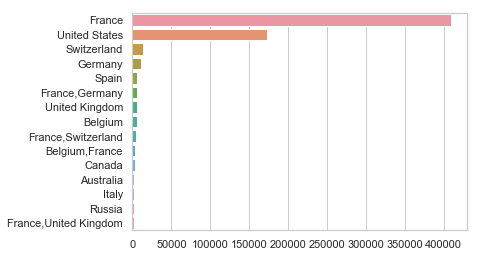

In [5]:
country_count = data["countries_en"].value_counts()[0:15]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)


In [6]:
us_product = data[data["countries_en"]=="United States"]
sel = ['categories_en', 'main_category_en', 'labels_en', 'origins_tags', 'manufacturing_places_tags', 
       'first_packaging_code_geo', 'countries_en']
us_product = us_product[sel]
us_product.head()

,categories_en,main_category_en,labels_en,origins_tags,manufacturing_places_tags,first_packaging_code_geo,countries_en
34,NaN,NaN,NaN,NaN,NaN,NaN,United States
35,NaN,NaN,NaN,NaN,NaN,NaN,United States
62,NaN,NaN,NaN,NaN,NaN,NaN,United States
63,NaN,NaN,NaN,NaN,NaN,NaN,United States
64,NaN,NaN,NaN,NaN,NaN,NaN,United States


Data from US are very incomplete ==> won't be useful for the analysis

# Data for distance computation

In [68]:
a = ~data["first_packaging_code_geo"].isnull() # 27572
b = ~data["origins_tags"].isnull()
c = ~data["manufacturing_places_tags"].isnull()

sele = a | b | c  # 88001

data_loc = data[sele] # 57688 (88001)
# print(data_loc.shape) # (88001, 173)

sel = ['categories_en', 'main_category_en', 'labels_en', 'origins_tags', 'manufacturing_places_tags', 
       'first_packaging_code_geo', 'countries_en']

data_loc = data_loc[sel]
data_loc

,categories_en,main_category_en,labels_en,origins_tags,manufacturing_places_tags,first_packaging_code_geo,countries_en
106,Dietary supplements,Dietary supplements,Made in France,NaN,france,NaN,France
251,"Meals,Meat-based products,Meals with meat,Poul...",Meals,"fr:Viande Française,Made in France",france,france,NaN,France
254,"Plant-based foods and beverages,Plant-based fo...",Plant-based foods and beverages,NaN,quebec,brossard-quebec,NaN,Canada
264,"Sugary snacks,Biscuits and cakes,Pastries",Sugary snacks,NaN,quebec,brossard-quebec,NaN,Canada
269,"Plant-based foods and beverages,Plant-based fo...",Plant-based foods and beverages,NaN,france,united-kingdom,NaN,United Kingdom
274,"Sugary snacks,Biscuits and cakes,Pastries",Sugary snacks,NaN,quebec,brossard-quebec,NaN,Canada
285,fr:Boulange,fr:Boulange,NaN,quebec,"brossard,quebec",NaN,Canada
289,"Beverages,Carbonated drinks,Sodas,Sugared beve...",Beverages,"Kosher,Contains GMOs",NaN,etats-unis,NaN,"France,United States"
292,"Sugary snacks,Biscuits and cakes,Biscuits,Shor...",Sugary snacks,Green Dot,NaN,"france,avranches",NaN,France
296,"Meals,Pizzas pies and quiches,Quiches,Lorraine...",Meals,NaN,quebec,"brossard,quebec",NaN,Canada


# TODO
* manage to have a start and a end point for the distance computation
* use the geopy pachaging, see what we can obtain from it

## Provenance country

In [69]:
prov = ['origins_tags', 'manufacturing_places_tags', 'first_packaging_code_geo']
data_from = data_loc[prov]
#print(data_from.shape) # (88001, 3)
data_from.head()

,origins_tags,manufacturing_places_tags,first_packaging_code_geo
106,NaN,france,NaN
251,france,france,NaN
254,quebec,brossard-quebec,NaN
264,quebec,brossard-quebec,NaN
269,france,united-kingdom,NaN


In [70]:
print(data_from['origins_tags'].dropna().shape) # 40'737
print(data_from['manufacturing_places_tags'].dropna().shape) # 65'380
print(data_from['first_packaging_code_geo'].dropna().shape) # 27'572

(40737,)
(65380,)
(27572,)


In [71]:
print(data_from['origins_tags'].value_counts().shape) # 6'606
print(data_from['manufacturing_places_tags'].value_counts().shape) # 11'731
print(data_from['first_packaging_code_geo'].value_counts().shape) # 2'103

(6606,)
(11731,)
(2103,)


In [72]:
origin_counts = data_from['origins_tags'].value_counts() # 6606
#print(type(origin_counts)) # Series
#origin_counts[origin_counts <= 5]
#origin_counts = origin_counts[origin_counts > 5] # 499 (4995 apparaissent 1 fois)
origin_counts = pd.DataFrame(origin_counts)
origin_counts

,origins_tags
france,11051
union-europeenne,1986
italie,969
espagne,889
mexico,814
espana,699
australia,462
suisse,382
deutschland,350
belgique,343


In [82]:
origin_counts['origine'] = origin_counts.index
origin_counts.head()

,origins_tags,origine
france,11051,france
union-europeenne,1986,union-europeenne
italie,969,italie
espagne,889,espagne
mexico,814,mexico


In [150]:
def fao2region(fao_number):  
    
    if '18' in fao_number: #Area 18 (Arctic Sea)
        l = 'Arctic Sea'
    elif '21' in fao_number: #Area 21 (Atlantic, Northwest)
        l = 'Atlantic, Northwest'
    elif '27' in fao_number: #Area 27 (Atlantic, Northeast)
        l = 'Atlantic, Northeast'
    elif '31' in fao_number: #Area 31 ( Atlantic, Western Central)
        l = 'Atlantic, Western Central'
    elif '34' in fao_number: #Area 34 (Atlantic, Eastern Central)
        l = 'Atlantic, Eastern Central'
    elif '37' in fao_number: #Area 37 (Mediterranean and Black Sea)
        l = 'Mediterranean and Black Sea'
    elif '41' in fao_number: #Area 41 (Atlantic, Southwest)
        l = 'Atlantic, Southwest'
    elif '47' in fao_number: #Area 47 (Atlantic, Southeast)
        l = 'Atlantic, Southeast'
    elif '48' in fao_number: #Area 48 (Atlantic, Antarctic)
        l = 'Atlantic, Antarctic'
    elif '51' in fao_number: #Area 51 (Indian Ocean, Western)
        l = 'Indian Ocean, Western'
    elif '57' in fao_number: #Area 57 (Indian Ocean, Eastern)
        l = 'Indian Ocean, Eastern'
    elif '58' in fao_number: #Area 58 (Indian Ocean, Antarctic and Southern)
        l = 'Indian Ocean, Antarctic and Southern'
    elif '61' in fao_number: #Area 61 (Pacific, Northwest)
        l = 'Pacific, Northwest'
    elif '67' in fao_number: #Area 67 (Pacific, Northeast)
        l = 'Pacific, Northeast'
    elif '71' in fao_number: #Area 71 (Pacific, Western Central)
        l = 'Pacific, Western Central'
    elif '77' in fao_number: #Area 77 (Pacific, Eastern Central)
        l = 'Pacific, Eastern Central'
    elif '81' in fao_number: #Area Area 81 (Pacific, Southwest)
        l = 'Pacific, Southwest'
    elif '87' in fao_number: #Area 87 (Pacific, Southeast)
        l = 'Pacific, Southeast'
    elif '88' in fao_number: #Area 88 (Pacific, Antarctic)
        l = 'Pacific, Antarctic'
    else:
        #print(l)
        #print(fao_number)
        return 'None'
        
    return l

In [264]:
import re

def checkValue(l):
    
    # fao handling
    if 'fao' in l:
        fao_number = re.sub("[^0-9]", ",", l)        
        tmp = fao2region(fao_number)
        
        if tmp == 'None':
            test = ['france','norvege','vietnam','chine','maldives']
            for i in range(len(test)):
                if test[i] in l:
                    l = test[i]
                    return l
            
            #print("EXCEPTION in fao handling " + l)
            return 'nan'
            
        else:
            return tmp

    # contradiction handling
    if '-no-' in l:
        return 'nan'
    
    if '-non-' in l:
        # non-precisee
        if 'non-precise' in l:
            #print("EXCEPTION in non-precisee handling " + l)
            return 'nan'
        
        # contradiction
        contradiction = ['agriculture-ue-non-ue','ue-non-ue','eu-and-non-eu','agriculture-ue-et-non-ue',
                        'eu-non-eu','eu-et-non-eu','ue-et-non-ue','union-europeenne-et-non-union-europeenne',
                        'ue-et-non-union-europeenne','eu-e-non-eu','u-e-et-non-u-e','ue-non-eu', 
                         'union-europeenne,et-non-eu','union-europeenne-non-union-europeenne',
                        'u-e-non-u-e','agricoltura-ue,agricoltura-non-ue','union-europeenne,et-non-ue',
                        'agriculture-eu,agriculture-non-eu']
        for i in range(len(contradiction)):
                if contradiction[i] in l:
                    l = contradiction[i]
                    return l
        
        # non-ue
        if 'agriculture-non-ue' in l:
            test = ['perou','turquie','madagascar','chine','equateur','amerique-latine','afrique-du-sud',
                   'moyen-orient','haiti','bolivie']
            for i in range(len(test)):
                if test[i] in l:
                    l = test[i]
                    return l
            
            #print("EXCEPTION in non-ue handling " + l)
            return 'nan'
            
        test = ['france','perou']
        for i in range(len(test)):
            if test[i] in l:
                l = test[i]
                return l
        
        return 'nan'
    
    if 'hors' in l:
        
        if 'union-europeenne,hors-union-europeenne' in l:
            print(l)
        
        
        
        #if 'hors-union-europeenne' in l:
            #print(l) 
        
        
        # contradiction
        #contradiction = ['france,hors-france','union-europeenne,hors-union-europeenne']
        #for i in range(len(contradiction)):
                #if contradiction[i] in l:
                    #l = contradiction[i]
                    #return l
    
        
        
                
        

        
        
    

In [265]:
origin_unique = origin_counts['origine'].unique()
origin_unique = pd.DataFrame(origin_unique)

In [266]:
#print(origin_unique.head())
print(origin_unique.shape)
#print(type(origin_unique))
origin_unique[0].apply(lambda l: checkValue(l))
print(origin_unique.shape)

(6606, 1)
union-europeenne,hors-union-europeenne
france,union-europeenne,hors-union-europeenne
union-europeenne,hors-union-europeenne,monde
union-europeenne,hors-union-europeenne,france
monde,union-europeenne,hors-union-europeenne
autriche,union-europeenne,hors-union-europeenne
ukraine,europe,union-europeenne,hors-union-europeenne
union-europeenne,hors-union-europeenne,europe,amerique-latine
union-europeenne,hors-union-europeenne,italie,sicile
union-europeenne,hors-union-europeenne,soja-de-filiere-france
equateur,perou,union-europeenne,hors-union-europeenne
ardeche,union-europeenne,hors-union-europeenne
chine,union-europeenne,hors-union-europeenne
union-europeenne,hors-union-europeenne,italie
farine-de-ble-france,france,union-europeenne,hors-union-europeenne
france,sud-ouest,sud-ouest-de-la-france,union-europeenne,hors-union-europeenne
union-europeenne,hors-union-europeenne,espagne,turquie
agricultura-ue,union-europeenne,hors-union-europeenne
union-europeenne,hors-union-europeenne,fran

In [73]:
origin_counts.to_csv('data/origin_counts.csv') 

In [30]:
origin_counts['origine'] = origin_counts.index
origin_counts.head()

,origins_tags,origine
france,11051,france
union-europeenne,1986,union-europeenne
italie,969,italie
espagne,889,espagne
mexico,814,mexico


In [ ]:
# check whether the place is recognize by geopy

In [27]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [31]:
origin_counts['Coord'] = origin_counts['origine'].apply(lambda x: geocode(x))

RateLimiter caught an error, retrying (0/2 tries). Called with (*('agricultura-ue-no-ue',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3.6/http/clie

RateLimiter caught an error, retrying (0/2 tries). Called with (*('allemagne,pays-bas',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/http/client.py", line 297, in begin
    ve

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 75 -> fr:75  ]  [ 7 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ ferments-lactiques -> fr:ferments-lactiques  ]  [ ferments -> fr:ferments  ]  [ lait -> fr:lait  ]  [ vitamine-d -> fr:vitamine-d  -> exists as a vitamin en:vitamin-d  ] ',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 532, in open
    response = meth(req,

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ fraise -> fr:fraise  ]  [ 20 -> fr:20  ]  [ mangue -> fr:mangue  ]  [ 10 -> en:fd-c  ]  [ abricot -> fr:abricot  ]  [ 9 -> en:fd-c  ]  [ 9 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ 9 -> en:fd-c  ]  [ 9 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 9 -> en:fd-c  ]  [ 9 -> en:fd-c  ]  [ figue -> fr:figue  ]  [ 9 -> en:fd-c  ]  [ 4 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 7 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ epaississants -> fr:epaississan

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 9 -> en:fd-c  ]  [ 7-en-moyenne -> fr:7-en-moyenne  ]  [ 7-en -> fr:7-en  ]  [ 7 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ mirabelle -> fr:mirabelle  ]  [ peche -> fr:peche  ]  [ abricot -> fr:abricot  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ amidon-transforme -> en:e14xx  -- already seen  ]  [ gomme-guar -> en:e412  -> exists  -- ok  ]  [ carraghenanes -> en:e407  -> exists  

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ abricot -> fr:abricot  ]  [ 13 -> fr:13  ]  [ fraise -> fr:fraise  ]  [ 10 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 10 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 8 -> en:fd-c  ]  [ 7 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ 8 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ cellules-de-citron -> fr:cellules-de-citron  ]  [ cellules-de -> fr:cellules-de  ]  [ cellules -> fr:cellules  ]  [ dans-la-variete-citron -> fr:dans-la-variete-citron  ]  [ dans-la-variete ->

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ yaourt -> fr:yaourt  ]  [ lait -> fr:lait  ]  [ sucre-8 -> fr:sucre-8  ]  [ sucre -> fr:sucre  ]  [ 2 -> en:fd-c  ]  [ fraise-5 -> fr:fraise-5  ]  [ fraise -> fr:fraise  ]  [ epaississant -> fr:epaississant  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ concentres-de-carotte-et-de-carotte-pourpre -> fr:concentres-de-carotte-et-de-carotte-pourpre  ]  [ concentres-de-carotte-et-de-carotte -> fr:concentres-de-carotte-et-de-carotte  ]  [ concentres-de-carotte-et-de -> fr:concentres-de-carotte-et-de  ]  [ concentres-de-carotte-et -> fr:concentres-de-carotte-et  ]  [ concentres-de-carotte -> fr:concentres-de-carotte  ]  [ concentres-de -> fr:concentres-de  ]  [ concentres -> fr:concentres  ]  [ arome -> fr:arome  ]  [ correcteurs-d-acidite -> fr:correcteurs-d-acidite  ]  [ correcteurs-d -> fr:correcteurs-d  ]  [ correcteurs -> fr:correcteurs  ]  [ citrate-de-sodium -> en:e331  -> exists  -- ok  ]  [ acide-citr

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ rhubarbe -> fr:rhubarbe  ]  [ 8 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 8 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ e1442 -> en:e1442  -> exists  -- ok  ]  [ e410 -> en:e410  -> exists  -- ok  ]  [ correcteurs-d-acidite -> fr:correcteurs-d-acidite  ]  [ correcteurs-d -> fr:correcteurs-d  ]  [ correcteurs -> fr:correcteurs  ]  [ e331 -> en:e331  -> exists  -- ok  ]  [ e330 -> en:e330  -> exists  -- ok  ]  [ arome -> fr:arome  ]  [ ferments-lactiques-dont-bifidobacterium -> fr:ferm

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 59-5 -> fr:59-5  ]  [ 59 -> fr:59  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 8 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ abricot -> fr:abricot  ]  [ 5 -> en:fd-c  ]  [ framboise -> fr:framboise  ]  [ 5 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ 5 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 5 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississant -> fr:epaississant  ]  [ e1422 -> en:e1422  -> exists  -- ok  ]  [ colorants -> fr:colorants  ]  [ e160a -> en:e1

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ ananas -> fr:ananas  ]  [ 8 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 7 -> en:fd-c  ]  [ 1 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ e1422 -> en:e1422  -> exists  -- ok  ]  [ e440 -> en:e440  -> exists  -- ok  ]  [ correcteurs-d-acidite -> fr:correcteurs-d-acidite  ]  [ correcteurs-d -> fr:correcteurs-d  ]  [ correcteurs -> fr:correcteurs  ]  [ e331 -> en:e331  -> exists  -- ok  ]  [ e330 -> en:e330  -> exists  -- ok  ]  [ e333 -> en:e333  -> exists  -- mandatory_additive_class: en

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier-69-5 -> fr:lait-entier-69-5  ]  [ lait-entier-69 -> fr:lait-entier-69  ]  [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ fraise-10 -> fr:fraise-10  ]  [ fraise -> fr:fraise  ]  [ mangue-10 -> fr:mangue-10  ]  [ mangue -> fr:mangue  ]  [ abricot-9-9 -> fr:abricot-9-9  ]  [ abricot-9 -> fr:abricot-9  ]  [ abricot -> fr:abricot  ]  [ kiwi-9-9 -> fr:kiwi-9-9  ]  [ kiwi-9 -> fr:kiwi-9  ]  [ kiwi -> fr:kiwi  ]  [ sucre-7-4-en-moyenne -> fr:sucre-7-4-en-moyenne  ]  [ sucre-7-4-en -> fr:sucre-7-4-en  ]  [ sucre-7-4 -> fr:sucre-7-4  ]  [ sucre-7 -> fr:sucre-7  ]  [ sucre -> fr:sucre  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-e

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier-69-5 -> fr:lait-entier-69-5  ]  [ lait-entier-69 -> fr:lait-entier-69  ]  [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ fraise-10 -> fr:fraise-10  ]  [ fraise -> fr:fraise  ]  [ mangue-10 -> fr:mangue-10  ]  [ mangue -> fr:mangue  ]  [ abricot-9-9 -> fr:abricot-9-9  ]  [ abricot-9 -> fr:abricot-9  ]  [ abricot -> fr:abricot  ]  [ kiwi-9-9 -> fr:kiwi-9-9  ]  [ kiwi-9 -> fr:kiwi-9  ]  [ kiwi -> fr:kiwi  ]  [ sucre-7-4-en-moyenne -> fr:sucre-7-4-en-moyenne  ]  [ sucre-7-4-en -> fr:sucre-7-4-en  ]  [ sucre-7-4 -> fr:sucre-7-4  ]  [ sucre-7 -> fr:sucre-7  ]  [ sucre -> fr:sucre  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecre

RateLimiter caught an error, retrying (1/2 tries). Called with (*('pays-bas,danemark',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/http/client.py", line 297, in begin
    ver

RateLimiter caught an error, retrying (0/2 tries). Called with (*('fitou,france,roussillon',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/http/client.py", line 297, in begin
 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('porc-origine-francomtois-igb-bbc',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3

RateLimiter caught an error, retrying (0/2 tries). Called with (*('inde,chine,indonesie,equateur',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3.6/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('jersey,royaume-uni',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3.6/http/client

RateLimiter swallowed an error after 2 retries. Called with (*('islande,russie',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3.6/http/client.py", l

RateLimiter swallowed an error after 2 retries. Called with (*('houblon-belgique',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3.6/http/client.py",

RateLimiter swallowed an error after 2 retries. Called with (*('lait-origine-ue-et-non-ue,ue-non-ue',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3

RateLimiter swallowed an error after 2 retries. Called with (*('hors-union-europeenne,perou',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super().connect()
  File "/anaconda3/lib/python3.6/http/

RateLimiter caught an error, retrying (0/2 tries). Called with (*('serbie,suisse,pologne,turquie,amerique-du-sud,burkina-faso,amerique-latine',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392, in connect
    super(

RateLimiter caught an error, retrying (1/2 tries). Called with (*('soja,sud-ouest,petit-epeautre,haute-provence,france,noisettes,sicile,italie,agriculture-ue-non-ue',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1392

RateLimiter swallowed an error after 2 retries. Called with (*('ardeche,union-europeenne,hors-union-europeenne',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1400, in connect
    server_hostname=server_hostname)
  Fi

RateLimiter caught an error, retrying (0/2 tries). Called with (*('viande-de-volaille-u-e',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/http/client.py", line 297, in begin
  

RateLimiter caught an error, retrying (0/2 tries). Called with (*('provincia-autonoma-de-bolzano,trentino-alto-adigio,italia',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/htt

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 73 -> fr:73  ]  [ 6 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ rhubarbe -> fr:rhubarbe  ]  [ figue -> fr:figue  ]  [ ananas -> fr:ananas  ]  [ 8 -> en:fd-c  ]  [ pruneau -> fr:pruneau  ]  [ 5-rehydrate -> fr:5-rehydrate  ]  [ 5 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 7 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ e1422 -> en:e1422  -> exists  -- ok  ]  [ e1442 -> en:e1442  -> exists  -- ok  ]  [ e440 -> e

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ cerise-8 -> fr:cerise-8  ]  [ cerise -> fr:cerise  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ pectine -> en:e440i  -> exists  -- ok  ]  [ correcteur-d-acidite -> fr:correcteur-d-acidite  ]  [ correcteur-d -> fr:correcteur-d  ]  [ correcteur -> fr:correcteur  ]  [ citrate-de-sodium -> en:e331  -> exists  -- ok  ]  [ acide-citrique -> en:e330  -> exists  -- ok  ]  [ aromes -> fr:aromes  ]  [ jus-concentre-de-carotte-noire -> fr:jus-concentre-de-carotte-noire  ]  [ jus-concentre-de-carott

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 78 -> fr:78  ]  [ fruits -> fr:fruits  ]  [ mangue -> fr:mangue  ]  [ abricot -> fr:abricot  ]  [ cerise -> fr:cerise  ]  [ 6 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ 5 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 4 -> en:fd-c  ]  [ 3 -> en:fd-c  ]  [ fructose -> fr:fructose  ]  [ 2 -> en:fd-c  ]  [ 8-en-moyenne -> fr:8-en-moyenne  ]  [ 8-en -> fr:8-en  ]  [ 8 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ puree-concentree-de-fraise -> fr:puree-concentree-de-fraise  ]  [ puree-concentree-de -> fr:puree-conce

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 78 -> fr:78  ]  [ fruits -> fr:fruits  ]  [ mangue -> fr:mangue  ]  [ abricot -> fr:abricot  ]  [ cerise -> fr:cerise  ]  [ 6 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ 5 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 4 -> en:fd-c  ]  [ 3 -> en:fd-c  ]  [ fructose -> fr:fructose  ]  [ 2 -> en:fd-c  ]  [ 8-en-moyenne -> fr:8-en-moyenne  ]  [ 8-en -> fr:8-en  ]  [ 8 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ puree-concentree-de-fraise -> fr:puree-concentree-de-fraise  ]  [ puree-concentree-de -> fr:puree-concentr

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 59 -> fr:59  ]  [ 5 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 5 -> en:fd-c  ]  [ 4 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ fruits-rouges -> fr:fruits-rouges  ]  [ fruits -> fr:fruits  ]  [ mure -> fr:mure  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ sirop-de-fructose-glucose -> fr:sirop-de-fructose-glucose  ]  [ sirop-de-fructose -> fr:sirop-de-fructose  ]  [ sirop-de -> fr:sirop-de  ]  [ sirop -> fr:sirop  ]  [ 3-5-en-moyenne -> fr:3-5-en-moyenne

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-demi-ecreme -> fr:lait-demi-ecreme  ]  [ lait-demi -> fr:lait-demi  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 6 -> en:fd-c  ]  [ 1 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ fructose -> fr:fructose  ]  [ 2 -> en:fd-c  ]  [ amidon -> fr:amidon  ]  [ proteines-de-lait -> fr:proteines-de-lait  ]  [ proteines-de -> fr:proteines-de  ]  [ proteines -> fr:proteines  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ gomme-guar -> en:e412  -> exists  -- ok  ]  [ citrate-de-calcium -> en:e333  -> exists  -- mandatory_additive_cl

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 80 -> fr:80  ]  [ 3 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 8 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ abricot -> fr:abricot  ]  [ mangue -> fr:mangue  ]  [ peche -> fr:peche  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ e1422 -> en:e1422  -> exists  -- ok  ]  [ e1442 -> en:e1442  -> exists  -- ok  ]  [ concentre-des-mineraux-du-lait -> fr:concentre-des-mineraux-du-lait  ]  [ concentre-des-mineraux-du -> fr:concentre-des-mineraux-du  ]  [ conce

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ ingredients -> fr:ingredients  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ abricot -> fr:abricot  ]  [ 8 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 8 -> en:fd-c  ]  [ 2 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ 6 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ jus-d-ananas-a-base-de-concentre -> fr:jus-d-ananas-a-base-de-concentre  ]  [ jus-d-ananas-a-base-de -> fr:jus-d-ananas-a-base-de  ]  [ jus-d-ananas-a-base -> fr:jus-d-ananas-a-base  ]  [ jus-d-ananas-a -> fr:jus-d-ananas-a  ]  [ jus-d-ananas -> fr:jus-d-ananas  ]  [ jus-d

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 9 -> en:fd-c  ]  [ 6-en-moyenne -> fr:6-en-moyenne  ]  [ 6-en -> fr:6-en  ]  [ 6 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ framboise -> fr:framboise  ]  [ fraise -> fr:fraise  ]  [ cerise -> fr:cerise  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ amidon-transforme -> en:e14xx  -- already seen  ]  [ gomme-guar -> en:e412  -> exists  -- ok  ]  [ carraghenanes -> en:e407  -> exists  

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 9 -> en:fd-c  ]  [ 6-en-moyenne -> fr:6-en-moyenne  ]  [ 6-en -> fr:6-en  ]  [ 6 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ framboise -> fr:framboise  ]  [ fraise -> fr:fraise  ]  [ cerise -> fr:cerise  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ amidon-transforme -> en:e14xx  -- already seen  ]  [ gomme-guar -> en:e412  -> exists  -- ok  ]  [ carraghenanes -> en:e407  -> exists  -- 

RateLimiter swallowed an error after 2 retries. Called with (*('eau-farine-de-ble-malte-levure-desactivee-agent-de-traitement-de-la-farine-e300-gluten-de-ble-farine-de-malt-partiellement-torrefiee-gruau-de-soja-grain-d-avoine-farine-d-orge-graines-de-lin-brun-farine-de-seigle-graine-de-tournesol-sel-3,6-extrait-d-orge-malte-matiere-grasse-vegetale-palme,farine-de-soja-levain-de-seigle-deshydrate-et-desactive-sirop-de-glucose-enzyme-alpha-amylase-hemicellulase-cellulose-lipase-exo-alpha-amylase-maltogene-graines-de-tournesol-20-graines-flocons-d-avoine-40-graines-de-lin-20-graines-de-sesame-20-graines-de-tournesol-20-levure-ameliorant-emulsifiant-e-471-palme-enzyme',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ 72 -> fr:72  ]  [ 6-en-moyenne -> fr:6-en-moyenne  ]  [ 6-en -> fr:6-en  ]  [ 6 -> en:fd-c  ]  [ origine-france -> fr:origine-france  ]  [ origine -> fr:origine  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ origine-ue -> fr:origine-ue  ]  [ origine -> fr:origine  ]  [ fruits -> fr:fruits  ]  [ fraise -> fr:fraise  ]  [ 8 -> en:fd-c  ]  [ 9 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ peche -> fr:peche  ]  [ 8 -> en:fd-c  ]  [ 1 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ cellules-de-citron -> fr:cellules-de-citron  ]  [ cellules-de -> fr:cellules-de  ]  [ cellules

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ origine -> fr:origine  ]  [ france -> fr:france  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ origine -> fr:origine  ]  [ ue -> fr:ue  ]  [ ferments-lactiques -> fr:ferments-lactiques  ]  [ ferments -> fr:ferments  ]  [ lait -> fr:lait  ]  [ vitamine-d -> fr:vitamine-d  -> exists as a vitamin en:vitamin-d  ] ',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 532, in open
    

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 59 -> fr:59  ]  [ 5 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 8 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ fruits-rouges -> fr:fruits-rouges  ]  [ fruits -> fr:fruits  ]  [ mure -> fr:mure  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ 5 -> en:fd-c  ]  [ framboise -> fr:framboise  ]  [ 5 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ 5 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ epaississant -> fr:epaississant  ]  [ amidon-transforme -> en:e14xx  -> exis

RateLimiter caught an error, retrying (1/2 tries). Called with (*('12-10-2018',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/http/client.py", line 297, in begin
    version, s

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ fraise-7-5 -> fr:fraise-7-5  ]  [ fraise-7 -> fr:fraise-7  ]  [ fraise -> fr:fraise  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ amidon -> fr:amidon  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ carraghenanes -> en:e407  -> exists  -- ok  ]  [ aromes -> fr:aromes  ]  [ correcteurs-d-acidite -> fr:correcteurs-d-acidite  ]  [ correcteurs-d -> fr:correcteurs-d  ]  [ correcteurs -> fr:correcteurs  ]  [ acide-lactique -> en:e270  -> exists  -- ok  ]  [ jus-de-carotte-pourpre-concentre -> fr:jus-de-carotte-pourpre-concentre  ]  [ jus-

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ abricot -> fr:abricot  ]  [ 13 -> fr:13  ]  [ fraise -> fr:fraise  ]  [ 10-8 -> fr:10-8  ]  [ 10 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 10 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 8-7 -> fr:8-7  ]  [ 8 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ 8-5 -> fr:8-5  ]  [ 8 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ cellules-de-citron -> fr:cellules-de-citron  ]  [ cellules-de -> fr:cellules-de  ]  [ cellules -> fr:cellules  ]  [ agent-de-charge -> fr:agent-de-charge  ]  [ agent-de -> fr:agent-de  ] 

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 9-6-en-moyenne -> fr:9-6-en-moyenne  ]  [ 9-6-en -> fr:9-6-en  ]  [ 9-6 -> fr:9-6  ]  [ 9 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ abricot -> fr:abricot  ]  [ peche -> fr:peche  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ amidons-transformes -> en:e14xx  -> exists  -- ok  ]  [ amidon-transforme -> en:e14xx  -- already seen  ]  [ gomme-guar-carraghenanes -> fr:gomme-guar-carr

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 9-6-en-moyenne -> fr:9-6-en-moyenne  ]  [ 9-6-en -> fr:9-6-en  ]  [ 9-6 -> fr:9-6  ]  [ 9 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ abricot -> fr:abricot  ]  [ peche -> fr:peche  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ amidons-transformes -> en:e14xx  -> exists  -- ok  ]  [ amidon-transforme -> en:e14xx  -- already seen  ]  [ gomme-guar-carraghenanes -> fr:gomme-guar-carragh

RateLimiter swallowed an error after 2 retries. Called with (*('farine-de-ble-bigarreau-rouge-correcteur-d-acidite-offre-et-beurre-sucre-ecorce-d-orange-raisins-maceres-levain-levure-sel-marin-oeuf-trace-de-soja',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.p

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 78 -> fr:78  ]  [ 1 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 8 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ eau -> fr:eau  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ gomme-xanthane -> en:e415  -> exists  -- ok  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ concentre-de-carotte-et-de-citrouille -> fr:concentre-de-carotte-et-de-citrouille  ]  [ concentre-de-carotte-et-de -> fr:concentre-de-carotte-et-de  ]  [ concentre-de-carotte-et -> fr:concentre-de-carotte-et  ]  [ concentre-de-carotte -> fr

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ fraise -> fr:fraise  ]  [ 8 -> en:fd-c  ]  [ 3 -> en:fd-c  ]  [ mangue -> fr:mangue  ]  [ 8 -> en:fd-c  ]  [ 3 -> en:fd-c  ]  [ kiwi -> fr:kiwi  ]  [ 8 -> en:fd-c  ]  [ abricot -> fr:abricot  ]  [ 8 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 7 -> en:fd-c  ]  [ 7-en-moyenne -> fr:7-en-moyenne  ]  [ 7-en -> fr:7-en  ]  [ 7 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ origine -> fr:origine  ]  [ ue -> fr:ue  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ e1422 -> en:e1422  -> exists  -- ok  ]  [ e407 -> 

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 80 -> fr:80  ]  [ 3 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 8 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ fruits -> fr:fruits  ]  [ 5 -> en:fd-c  ]  [ framboise -> fr:framboise  ]  [ fraise -> fr:fraise  ]  [ fruits-rouges -> fr:fruits-rouges  ]  [ fruits -> fr:fruits  ]  [ mure -> fr:mure  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ epaississants -> fr:epaississants  ]  [ e1422 -> en:e1422  -> exists  -- ok  ]  [ e1442 -> en:e1442  -> exists  -- ok  ]  [ concentre-des-

RateLimiter caught an error, retrying (0/2 tries). Called with (*('atlantique-nord-ouest,atlantique-nord-est',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/anaconda3/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/anaconda3/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/anaconda3/lib/python3.6/http/client.py", line 964, in send
    self.connect()
  File "/anaconda3/lib/python3.6/http/client.py", line 1400, in connect
    server_hostname=server_hostname)
  File

RateLimiter caught an error, retrying (0/2 tries). Called with (*('15-مكعبات-انناس-نسبة-العصير-15-نسبة-المحلول-السكري-14-حامض-الليمون-e-330-النسبة-0-23-سكرات-الصوديوم-e-331-مادة-حافظة-e-211-فيتامين-سي-e-300',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", l

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ cerise -> fr:cerise  ]  [ 8 -> en:fd-c  ]  [ 0 -> fr:0  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ amidon -> fr:amidon  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ pectine -> en:e440i  -> exists  -- ok  ]  [ correcteur-d-acidite -> fr:correcteur-d-acidite  ]  [ correcteur-d -> fr:correcteur-d  ]  [ correcteur -> fr:correcteur  ]  [ citrate-de-sodium -> en:e331  -> exists  -- ok  ]  [ acide-citrique -> en:e330  -> exists  -- ok  ]  [ jus-de-carotte-pourpre-concentre -> fr:jus-de-carotte-pourpre-concentre  ]  [ jus-de-carotte

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ origine -> fr:origine  ]  [ france -> fr:france  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ origine -> fr:origine  ]  [ ue -> fr:ue  ]  [ fruits -> fr:fruits  ]  [ 7 -> en:fd-c  ]  [ 2-en-moyenne -> fr:2-en-moyenne  ]  [ 2-en -> fr:2-en  ]  [ 2 -> en:fd-c  ]  [ fraise -> fr:fraise  ]  [ framboise -> fr:framboise  ]  [ cerise -> fr:cerise  ]  [ myrtille -> fr:myrtille  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ pectine -> en:e440i  -> exists  -- ok  ]  [ carraghenanes -> en:e407  -> exists  -- ok  ]  [ jus-concentres-de-car

RateLimiter caught an error, retrying (0/2 tries). Called with (*('belgique,pays-bas,france',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.getresponse()
  File "/anaconda3/lib/python3.6/http/client.py", line 1331, in getresponse
    response.begin()
  File "/anaconda3/lib/python3.6/http/client.py", line 297, in begin


RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ fraise -> fr:fraise  ]  [ 12 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 10 -> en:fd-c  ]  [ framboise -> fr:framboise  ]  [ 10 -> en:fd-c  ]  [ myrtille -> fr:myrtille  ]  [ 7 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre-agent-de-charge -> fr:lait-ecreme-concentre-ou-en-poudre-agent-de-charge  ]  [ lait-ecreme-concentre-ou-en-poudre-agent-de -> fr:lait-ecreme-concentre-ou-en-poudre-agent-de  ]  [ lait-ecreme-concentre-ou-en-poudre-agent -> fr:lait-ecreme-concentre-ou-en-poudre-agent  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ polydextrose -> en:

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ abricot -> fr:abricot  ]  [ 13 -> fr:13  ]  [ fraise -> fr:fraise  ]  [ 10 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 10 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 8 -> en:fd-c  ]  [ 7-ananas -> fr:7-ananas  ]  [ 7 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ cellules-de-citron -> fr:cellules-de-citron  ]  [ cellules-de -> fr:cellules-de  ]  [ cellules -> fr:cellules  ]  [ dans-la-variete-citron -> fr:dans-la-variete-citron  ]  [ dans-la-variet

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ fruits -> fr:fruits  ]  [ abricot -> fr:abricot  ]  [ 13 -> fr:13  ]  [ fraise -> fr:fraise  ]  [ 10 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 10 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 8 -> en:fd-c  ]  [ 7-ananas -> fr:7-ananas  ]  [ 7 -> en:fd-c  ]  [ 8 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ cellules-de-citron -> fr:cellules-de-citron  ]  [ cellules-de -> fr:cellules-de  ]  [ cellules -> fr:cellules  ]  [ dans-la-variete-citron -> fr:dans-la-variete-citron  ]  [ dans-la-variete -

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ abricot -> fr:abricot  ]  [ 8 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ peche -> fr:peche  ]  [ 8 -> en:fd-c  ]  [ 2 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 8 -> en:fd-c  ]  [ 0 -> fr:0  ]  [ fraise -> fr:fraise  ]  [ 7 -> en:fd-c  ]  [ 5 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ 6 -> en:fd-c  ]  [ 6 -> en:fd-c  ]  [ citron -> fr:citron  ]  [ 2 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ jus-d-ananas-a-base-de-concentre -> fr:jus-d-ananas-a-base-de-concentre  ]  [ jus-d-ananas-a-base-de -> fr:jus-d-ananas-a-base-de  ]  [ jus-d-ananas-a-base -> fr:jus-d-ananas-a-base  ]

RateLimiter caught an error, retrying (0/2 tries). Called with (*(' [ lait-demi-ecreme -> fr:lait-demi-ecreme  ]  [ lait-demi -> fr:lait-demi  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 6 -> en:fd-c  ]  [ 1 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ fructose -> fr:fructose  ]  [ 2 -> en:fd-c  ]  [ amidon -> fr:amidon  ]  [ proteines-de-lait -> fr:proteines-de-lait  ]  [ proteines-de -> fr:proteines-de  ]  [ proteines -> fr:proteines  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ gomme-guar -> en:e412  -> exists  -- ok  ]  [ concentre-de-carotte-et-de-citrouille -> fr:concentre-de-carott

RateLimiter swallowed an error after 2 retries. Called with (*(' [ lait-demi-ecreme -> fr:lait-demi-ecreme  ]  [ lait-demi -> fr:lait-demi  ]  [ lait -> fr:lait  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ sucre -> fr:sucre  ]  [ 6 -> en:fd-c  ]  [ 1 -> en:fd-c  ]  [ creme -> fr:creme  ]  [ lait -> fr:lait  ]  [ fructose -> fr:fructose  ]  [ 2 -> en:fd-c  ]  [ amidon -> fr:amidon  ]  [ proteines-de-lait -> fr:proteines-de-lait  ]  [ proteines-de -> fr:proteines-de  ]  [ proteines -> fr:proteines  ]  [ epaississants -> fr:epaississants  ]  [ amidon-transforme -> en:e14xx  -> exists  -- ok  ]  [ gomme-guar -> en:e412  -> exists  -- ok  ]  [ concentre-de-carotte-et-de-citrouille -> fr:concentre-de-carotte-e

RateLimiter swallowed an error after 2 retries. Called with (*('morocco,lait-ecreme,creme,sucre,ferments-lactiques-matiere-cinq-an,lait-ecreme,creme,sucre,ferments-lactiques-matiere-grosse-3,sa-premiere-date-de-publication-au-maroc-01-10-1993-le-changement-du-packaging-10-ans-par-10-ans-depuis-vingt-cinq-ans-de-l-offre',), **{}).
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/anaconda3/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/anaconda3/lib/python3.6/url

RateLimiter caught an error, retrying (1/2 tries). Called with (*(' [ lait-entier -> fr:lait-entier  ]  [ lait -> fr:lait  ]  [ 72-1 -> fr:72-1  ]  [ 72 -> fr:72  ]  [ fruits -> fr:fruits  ]  [ fraise -> fr:fraise  ]  [ 8-3 -> fr:8-3  ]  [ 8 -> en:fd-c  ]  [ mangue -> fr:mangue  ]  [ 8-2 -> fr:8-2  ]  [ 8 -> en:fd-c  ]  [ abricot -> fr:abricot  ]  [ 8 -> en:fd-c  ]  [ ananas -> fr:ananas  ]  [ 8 -> en:fd-c  ]  [ cerise -> fr:cerise  ]  [ 8 -> en:fd-c  ]  [ figue -> fr:figue  ]  [ 8 -> en:fd-c  ]  [ sucre -> fr:sucre  ]  [ 7 -> en:fd-c  ]  [ 5-en-moyenne -> fr:5-en-moyenne  ]  [ 5-en -> fr:5-en  ]  [ 5 -> en:fd-c  ]  [ lait-ecreme-concentre-ou-en-poudre -> fr:lait-ecreme-concentre-ou-en-poudre  ]  [ lait-ecreme-concentre-ou-en -> fr:lait-ecreme-concentre-ou-en  ]  [ lait-ecreme-concentre-ou -> fr:lait-ecreme-concentre-ou  ]  [ lait-ecreme-concentre -> fr:lait-ecreme-concentre  ]  [ lait-ecreme -> fr:lait-ecreme  ]  [ lait -> fr:lait  ]  [ creme -> fr:creme  ]  [ epaississants -> fr:epai

In [32]:
origin_counts_save = origin_counts

In [33]:
origin_counts

,origins_tags,origine,Coord
france,11051,france,"(France métropolitaine, France, (46.603354, 1...."
union-europeenne,1986,union-europeenne,"(European Union, Άμπελος, Δήμος Γαύδου, Περιφε..."
italie,969,italie,"(Italia, (42.6384261, 12.674297))"
espagne,889,espagne,"(España, (39.3262345, -4.8380649))"
mexico,814,mexico,"(Ciudad de México, Cuauhtémoc, 06060, México, ..."
espana,699,espana,"(España, (39.3262345, -4.8380649))"
australia,462,australia,"(Australia, (-24.7761086, 134.755))"
suisse,382,suisse,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ..."
deutschland,350,deutschland,"(Deutschland, Europe, (51.0834196, 10.4234469))"
belgique,343,belgique,"(België / Belgique / Belgien, (50.6402809, 4.6..."


In [34]:
origin_counts['Point'] = origin_counts['Coord'].apply(lambda x: tuple(x.point) if x else None)
origin_counts['Coord_x'] = origin_counts['Point'].apply(lambda x: x[0] if x else None)
origin_counts['Coord_y'] = origin_counts['Point'].apply(lambda x: x[1] if x else None)

In [35]:
origin_counts

,origins_tags,origine,Coord,Point,Coord_x,Coord_y
france,11051,france,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335, 0.0)",46.603354,1.888334
union-europeenne,1986,union-europeenne,"(European Union, Άμπελος, Δήμος Γαύδου, Περιφε...","(34.8696391, 24.068801347645, 0.0)",34.869639,24.068801
italie,969,italie,"(Italia, (42.6384261, 12.674297))","(42.6384261, 12.674297, 0.0)",42.638426,12.674297
espagne,889,espagne,"(España, (39.3262345, -4.8380649))","(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065
mexico,814,mexico,"(Ciudad de México, Cuauhtémoc, 06060, México, ...","(19.4326009, -99.1333416, 0.0)",19.432601,-99.133342
espana,699,espana,"(España, (39.3262345, -4.8380649))","(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065
australia,462,australia,"(Australia, (-24.7761086, 134.755))","(-24.7761086, 134.755, 0.0)",-24.776109,134.755000
suisse,382,suisse,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ...","(46.7985624, 8.2319736, 0.0)",46.798562,8.231974
deutschland,350,deutschland,"(Deutschland, Europe, (51.0834196, 10.4234469))","(51.0834196, 10.4234469, 0.0)",51.083420,10.423447
belgique,343,belgique,"(België / Belgique / Belgien, (50.6402809, 4.6...","(50.6402809, 4.6667145, 0.0)",50.640281,4.666715


In [37]:
origin_counts.to_csv('data/Origine-Coordinate-raw.csv')

In [38]:
print(origin_counts.shape)
origin_counts = origin_counts.dropna()
print(origin_counts.shape)

(6606, 6)
(3188, 6)


In [39]:
origin_counts.to_csv('data/Origine-Coordinate.csv')

In [20]:
manufacturing_counts = data_from['manufacturing_places_tags'].value_counts()
#print(manufacturing_counts.shape) # 11731
#manufacturing_counts = manufacturing_counts[manufacturing_counts > 5] # 839 
manufacturing_counts

france                                                                                                                               18599
italie                                                                                                                                2428
belgique                                                                                                                              1420
suisse                                                                                                                                1258
allemagne                                                                                                                             1246
deutschland                                                                                                                           1123
espagne                                                                                                                               1040
espana                     

In [271]:
origin_counts = pd.read_csv('data/Origine-Coordinate.csv',delimiter=',',low_memory=False)
#manufacturing_counts = pd.read_csv('data/Origine-Coordinate.csv',delimiter=',',low_memory=False)
manufacturing_counts = pd.read_csv('data/Manufacturing-Coordinate.csv',delimiter=',',low_memory=False)

In [272]:
origin_counts.index = origin_counts['Unnamed: 0']
origin_counts = origin_counts.drop(columns=['Unnamed: 0'])
origin_counts.head()

,origins_tags,origine,Coord,Point,Coord_x,Coord_y
Unnamed: 0,,,,,,
france,11051,france,"France métropolitaine, France","(46.603354, 1.8883335, 0.0)",46.603354,1.888333
union-europeenne,1986,union-europeenne,"European Union, Άμπελος, Δήμος Γαύδου, Περιφερ...","(34.8696391, 24.068801347645, 0.0)",34.869639,24.068801
italie,969,italie,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297
espagne,889,espagne,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065
mexico,814,mexico,"Ciudad de México, Cuauhtémoc, 06060, México","(19.4326009, -99.1333416, 0.0)",19.432601,-99.133342


In [274]:
manufacturing_counts.index = manufacturing_counts['Unnamed: 0']
manufacturing_counts = manufacturing_counts.drop(columns=['Unnamed: 0'])
manufacturing_counts.head()

,manufacturing_places_tags,origine,Coord,Point,Coord_x,Coord_y
Unnamed: 0,,,,,,
france,18599,france,"France métropolitaine, France","(46.603354, 1.8883335, 0.0)",46.603354,1.888333
italie,2428,italie,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297
belgique,1420,belgique,België / Belgique / Belgien,"(50.6402809, 4.6667145, 0.0)",50.640281,4.666714
suisse,1258,suisse,Schweiz/Suisse/Svizzera/Svizra,"(46.7985624, 8.2319736, 0.0)",46.798562,8.231974
allemagne,1246,allemagne,"Deutschland, Europe","(51.0834196, 10.4234469, 0.0)",51.083420,10.423447


In [275]:
def findFrom(x):
    #print(x['origins_tags'])
    #print(x['manufacturing_places_tags'])
    #print(x['first_packaging_code_geo'])
    
    origine = str(x['origins_tags'])
    manufacturing = str(x['manufacturing_places_tags'])
    packaging = str(x['first_packaging_code_geo'])
    
    #print(origine + " , " + manufacturing + " , " + packaging)
    
    #if manufacturing == 'net-wt':
    #    manufacturing = 'nan'
    
    if manufacturing in manufacturing_counts.index:
        manufacturing
    else:
        manufacturing = 'nan'
        
        
    if origine in origin_counts.index:
        manufacturing
    else:
        origine = 'nan' 
        
    #checklist = ['indetermine', 'more-than-one-country', 'inconnue', 'inconnu']
    checklist = ['indetermine', 'inconnu', 'biologique','sud-ouest', 'importe', 'unknown', 'diverses',
                 'fao-27','fao-34', 'fao-67', 'fao-n-27', 'fao-71', '2017', 'fao-n-71', 'fao-51',
                 'ue,hors-ue', 'eua', 'non-eu', 'ue-et-hors-ue', 'ue-non-ue', 'eu-non-eu', 'uae', 
                 'ue-non-ue,ue,non-ue', 'non-union-europeenne', 'hors-ue', 'igp', 'ce,hors-ce',
                'france,hors-france']
        
    if manufacturing in checklist:
        manufacturing = 'nan'
        
    if origine in checklist:    
        origine = 'nan'
        
    
    if (origine == 'nan' and manufacturing == 'nan'):
        #print('case 1')
        return  x['first_packaging_code_geo']
    
    elif (origine == 'nan'): # packaging == 'nan' and 
        #print('case 3')
        return  x['manufacturing_places_tags']
    
    elif (manufacturing == 'nan'): # packaging == 'nan' and 
        #print('case 2')
        return  x['origins_tags']
    
    elif (origine == manufacturing):
        return  x['origins_tags']
    
    else :
        print('Several answers : ' + origine + ' ' + manufacturing)
        return  x['origins_tags']
        #print(x['origins_tags'])
        #print(x['manufacturing_places_tags'])
        #print(x['first_packaging_code_geo'])
    

In [276]:
data_from['From'] = data_from.apply(lambda x: findFrom(x), axis = 1)

Several answers : quebec brossard-quebec
Several answers : quebec brossard-quebec
Several answers : france united-kingdom
Several answers : quebec brossard-quebec
Several answers : quebec brossard,quebec
Several answers : quebec brossard,quebec
Several answers : quebec brossard-quebec
Several answers : france sarlat
Several answers : france 87500-saint-yrieix
Several answers : europe,royaume-uni royaume-uni
Several answers : united-states china
Several answers : grande-bretagne royaume-uni
Several answers : madagascar italie
Several answers : united-states cincinnati
Several answers : estados-unidos san-nicolas-de-los-garza,nuevo-leon
Several answers : california san-francisco-california
Several answers : estero italia
Several answers : estados-unidos plymouth,wisconsin
Several answers : britain,british-chicken united-kingdom
Several answers : fougerolles,france france
Several answers : mexico united-kingdom
Several answers : ancaster,ontario,canada ancaster,ontario
Several answers : s

Several answers : valencia-provincia,comunidad-valenciana,espana jativa,valencia-provincia,comunidad-valenciana,espana
Several answers : agricultura-ue arroniz,navarra,espana
Several answers : granada-provincia,andalucia,espana motril,granada-provincia,andalucia,espana
Several answers : espana benifairo-de-les-valls,valencia-provincia,comunidad-valenciana,espana
Several answers : huelva-provincia,andalucia,espana lepe,huelva-provincia,andalucia,espana
Several answers : france bretagne,france
Several answers : italy great-britain
Several answers : italy great-britain
Several answers : holanda lidl
Several answers : italia,parma italia-parma
Several answers : mexique france-45-la-ferte-st-aubin
Several answers : bamako-au-mali bamako
Several answers : france sarthe,france
Several answers : bourgogne italie
Several answers : france,ardeche ardeche
Several answers : poland bialystok
Several answers : espana benisano,valencia-provincia,comunidad-valenciana,espana
Several answers : espana pu

Several answers : france doubs
Several answers : france,bigorre france
Several answers : espagne suisse
Several answers : artisanale grand-fougeray
Several answers : sao-miguel,acores ribeira-seca,ribeira-grande,sao-miguel,acores,portugal
Several answers : acores,portugal ponta-delgada,acores,portugal
Several answers : alsace 5-rue-de-la-charente-68271-wittenheim
Several answers : union-europeenne france
Several answers : ue allemagne
Several answers : union-europeenne allemagne
Several answers : union-europeenne allemagne
Several answers : union-europeenne allemagne
Several answers : union-europeenne allemagne
Several answers : suisse dagmersellen-lu,suisse
Several answers : eu frankreich
Several answers : austria wien,austria
Several answers : france france,bretagne
Several answers : france france,bretagne,finistere,bannalec
Several answers : grece suisse
Several answers : deutschland,irland deutschland
Several answers : suisse,switzerland suisse
Several answers : 29-08-2018 fillinge

Several answers : union-europeenne france
Several answers : france,champagne reims,marne,grand-est,france
Several answers : ocean-indien seychelles
Several answers : ocean-indien france,bretagne
Several answers : ocean-atlantique portugal
Several answers : ouest-pacifique france
Several answers : ocean-atlantique ghana
Several answers : ocean-atlantique finistere,bretagne,france
Several answers : ocean-atlantique portugal
Several answers : pecherie seychelles
Several answers : ocean-indien seychelles
Several answers : ocean-pacifique france
Several answers : drome bren
Several answers : france france,pouldreuzic,bretagne
Several answers : france france,finistere,bretagne,pouldreuzic
Several answers : amerique-du-sud pouldreuzic,finistere,france
Several answers : bresil,argentine france,bretagne
Several answers : france espagne
Several answers : union-europeenne france
Several answers : france france,lot-et-garonne
Several answers : union-europeenne france
Several answers : france,norma

Several answers : ecosse scotland
Several answers : savoie frangy
Several answers : france pas-de-calais,france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : france france,normandie
Several answers : pays-bas pays-bas,friesland-campina
Several answers : france france,bretagne
Several answers : france 35240-retiers
Several answers : inconnue france
Several answers : union-europeenne france
Several answers : bretagne,france france,bretagne
Several answers : lorraine paris-75008
Several answers : curcuma france
Several answers : normandie normandie,france
Several answers : france gouvieux
Several answers : france france,nord-pas-de-calais
Several answers : france france,nord-pas-de-calais
Several answers : provence,france france,sologne
Several answers : espagne france
Several answers : atlantique-nord-est bretagne,france
Several answers : france,grande-bretagne france
Several answers : norvege france
Several answers : mer-du-nord no

Several answers : equateur france
Several answers : union-europeenne dole,jura,bourgogne-franche-comte,france
Several answers : union-europeenne obernai,france
Several answers : union-europeenne france
Several answers : sud-ouest,france france
Several answers : norvege france
Several answers : cotentin 50500-meautis
Several answers : bretagne,france bretagne
Several answers : france plouvien
Several answers : atlantique-centre-ouest france
Several answers : union-europeenne ille-et-vilaine,france
Several answers : sud-ouest,france france
Several answers : italie roseto-degli-abruzzi,italie
Several answers : ue-et-non-ue italie
Several answers : france sarthe,france
Several answers : france italie
Several answers : mexico estado-de-mexico
Several answers : mexico estado-de-mexico
Several answers : mexico estado-de-mexico
Several answers : france normandie,france
Several answers : normandie lonlay-l-abbaye
Several answers : france france,alpes-de-haute-provence
Several answers : france f

Several answers : france saint-fulgent,vendee,pays-de-la-loire,france
Several answers : france theix,morbihan,bretagne,france
Several answers : france theix,morbihan,bretagne,france
Several answers : france,union-europeenne france,ille-et-vilaine
Several answers : france,union-europeenne france
Several answers : france,ue quimper,bretagne,france
Several answers : france,union-europeenne morbihan,bretagne,france
Several answers : france bretagne,france
Several answers : france merville
Several answers : france saint-maurice-de-lignon
Several answers : france 56550-local-mendon
Several answers : france saint-pere-en-retz
Several answers : france haute-loire,auvergne-rhone-alpes,france
Several answers : france france,bouvron
Several answers : france locoal-mendon,france
Several answers : norvege chateaulin-en-bretagne
Several answers : france,union-europeenne france
Several answers : france,union-europeenne france
Several answers : espagne chateaulin
Several answers : france,bretagne fran

Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : equateur france
Several answers : cuba,sierra-maestra france
Several answers : france nyons,france
Several answers : raisins nyons
Several answers : camargue,france france
Several answers : camargue,france france
Several answers : camargue,france france
Several answers : france nord,douai,france
Several answers : france ploumagoar,france
Several answers : australie france
Several answers : france,provence france,normandie
Several answers : france,provence normandie,france
Several answers : union-europeenne allemagne
Several answers : maroc nyons,france
Several answers : maroc nyons,drome,france
Several answers : espagne nyons,drome,france

Several answers : union-europeenne france
Several answers : union-europeenne pays-bas
Several answers : france,belgique france
Several answers : pologne france
Several answers : france france,cotes-d-armor,bretagne
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : italie france
Several answers : thailande allemagne
Several answers : union-europeenne,france france
Several answers : france,agen france
Several answers : savoie,france france
Several answers : france,savoie france
Several answers : france belgique
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : pologne france
Several answers : france belgique
Several answers : france,union-europeenne france
Several answers : union-europeenne belgique
Several answers : france,bretagne,charentes-poitou france
Several answers : grande-bretagne france
Several answers : france,bretagne france
Several

Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : france france,provence
Several answers : union-europeenne france
Several answers : turquie,france france
Several answers : danemark france,troarn,14670
Several answers : france vendee
Several answers : france vendee
Several answers : france vendee
Several answers : france france,sarthe
Several answers : france,union-europeenne france
Several answers : ue,non-ue france
Several answers : tunisie marseille
Several answers : ardeche,france france
Several answers : montagne annecy-le-vieux,haute-savoie,rhone-alpes,france
Several answers : france savoie,france
S

Several answers : sud-ouest,france france
Several answers : france,sud-ouest-de-la-france france
Several answers : agriculture-ue 73000-chambery,savoie,rhone-alpes,france
Several answers : union-europeenne espagne
Several answers : union-europeenne france
Several answers : royaume-uni ecosse
Several answers : irlande france
Several answers : sud-ouest,france france
Several answers : union-europeenne france
Several answers : agriculture-biologique france
Several answers : alaska france,bretagne
Several answers : union-europeenne france
Several answers : ue,non-ue suisse
Several answers : united-states belgium
Several answers : france france,sarthe
Several answers : france france-sarthe
Several answers : france,franche-comte france,nozeroy
Several answers : france,isigny,normandie france
Several answers : union-europeenne france,bretagne
Several answers : tahiti,polynesie-francaise moorea,polynesie-francaise
Several answers : polynesie-francaise moorea
Several answers : polynesie-francai

Several answers : france nord,france
Several answers : union-europeenne savoie,france
Several answers : france savoie,france
Several answers : france gironde
Several answers : bordeaux,france france
Several answers : union-europeenne france
Several answers : madagascar seine-maritime,france
Several answers : inde st-aignan-de-grand-lieu-44860,france
Several answers : france,provence france
Several answers : france france,provence
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : france,revelles,picardie,somme france
Several answers : israel somme,france
Several answers : france somme,france
Several answers : champagne reims,france
Several answers : val-de-loire les-hauts-d-anjou
Several answers : corse 20167-sarrola-carcopino,corse,france
Several answers : france france,corse
Several answers : corse sarrola-carcopino
Several answers : corse,france france,corse
Several answers : corse,france france,corse
Several answers : espagne franc

Several answers : union-europeenne france
Several answers : italie,campanie italie,81030-castel-volturno
Several answers : pacifique-nord-est etats-unis
Several answers : atlantique-nord-est norvege
Several answers : italie 73000-chambery,savoie,rhone-alpes,france
Several answers : norvege danemark
Several answers : perou france
Several answers : inconnue france,alpes-maritimes,carros
Several answers : union-europeenne-non-union-europeenne france
Several answers : norvege danemark
Several answers : union-europeenne france
Several answers : sudafrica alicante,alicante-provincia,comunidad-valenciana,espana
Several answers : france,belgique,pays-bas france,belgique
Several answers : espagne,chili france
Several answers : france normandie,france
Several answers : union-europeenne allemagne
Several answers : espana autol,la-rioja,espana
Several answers : france corse,france
Several answers : ue,non-ue france
Several answers : union-europeenne france
Several answers : union-europeenne allema

Several answers : union-europeenne belgique
Several answers : union-europeenne italie
Several answers : union-europeenne italie
Several answers : france 47200,marmande,lot-et-garonne,nouvelle-aquitaine,france
Several answers : inde,pakistan france
Several answers : bresil belgique
Several answers : ethiopie france
Several answers : atlantique-nord-est france
Several answers : union-europeenne france
Several answers : france quincie-en-beaujolais
Several answers : ue,non-ue italie
Several answers : union-europeenne italie
Several answers : ethiopie france
Several answers : bresil france
Several answers : france,union-europeenne france
Several answers : union-europeenne france
Several answers : importation belgique
Several answers : union-europeenne france
Several answers : agriculture-ue belgique
Several answers : france abbeville
Several answers : union-europeenne france,union-europeenne
Several answers : mexique,kenya espagne
Several answers : thailande belgique
Several answers : turq

Several answers : france belgique
Several answers : france belgique
Several answers : inde allemagne
Several answers : perou france
Several answers : perou france
Several answers : republique-dominicaine,saint-domingue saint-etienne,france
Several answers : mexique france
Several answers : france france,gironde
Several answers : union-europeenne france
Several answers : france le-lion-d-angers,france
Several answers : union-europeenne les-mates
Several answers : valois,france france
Several answers : atlantique-nord-est bourbourg,nord,nord-pas-de-calais,france
Several answers : provence,france aix-en-provence,france
Several answers : union-europeenne tulette,france
Several answers : vendee,france france
Several answers : france lyon,france
Several answers : union-europeenne italie
Several answers : union-europeenne marseille,france
Several answers : costa-rica france
Several answers : norvege pologne
Several answers : france taninges,haute-savoie
Several answers : norvege france
Severa

Several answers : nord,france france
Several answers : france lectoure,france
Several answers : france 41370-talcy,france
Several answers : ue lupstein-67490-france
Several answers : 03-2018 republique-populaire-de-chine
Several answers : ue-et-non-ue france
Several answers : perou france
Several answers : sud-ouest,france france
Several answers : sud-ouest,france france
Several answers : sud-ouest,france france
Several answers : sud-ouest,france france
Several answers : france,pays-bas france
Several answers : france france,beaune
Several answers : normandie,france 50450,gavray,manche,normandie,france
Several answers : amerique-du-sud france
Several answers : union-europeenne france
Several answers : turquie france
Several answers : import france
Several answers : portugal france
Several answers : italie 25023-gottolengo-bs-i
Several answers : france,val-de-loire france
Several answers : france,sud-de-la-france france
Several answers : france provence
Several answers : noirmoutier ven

Several answers : normandie 76270-fesques
Several answers : france france,auvergne
Several answers : france france,auvergne
Several answers : norvege france
Several answers : france,doubs france
Several answers : france novillers
Several answers : agriculture-biologique 60400-noyon
Several answers : france saint-genes-de-blaye,france
Several answers : lorraine,france meurthe-et-moselle,france
Several answers : france,nord epinay
Several answers : france,haut-doubs france
Several answers : france france,vendee
Several answers : vietnam castelnaudary,france
Several answers : vietnam castelnaudary,france
Several answers : france france,gironde
Several answers : france,languedoc-roussillon france,bages
Several answers : france france,drome
Several answers : bassin-mediterraneen france
Several answers : france 26400-allex
Several answers : france,italie revest-du-bion,france
Several answers : france,alpes-de-haute-provence france,revest-du-bion
Several answers : france vertou,france
Several

Several answers : vaucluse carpentras
Several answers : france,cote-d-opale france,boulogne-billancourt
Several answers : france,bourgogne france
Several answers : france pays-d-oc
Several answers : france provence
Several answers : haut-rhin wittenheim
Several answers : agriculture-ue nantes,france
Several answers : agriculture-ue nantes,france
Several answers : agriculture-ue nantes,france
Several answers : agriculture-ue nantes,france
Several answers : france 43340-st-haon
Several answers : france,normandie,senonches france,normandie
Several answers : france france,normandie,perche
Several answers : france,senonches france,normandie
Several answers : france france,senonches
Several answers : perche damigny
Several answers : france medreac
Several answers : france,republique-dominicaine france
Several answers : france,camargue france
Several answers : bretagne,france montreuil-le-gast,france
Several answers : france france,bretagne
Several answers : france montreuil-le-gast,france
Se

Several answers : eu deutschland
Several answers : frankrijk vigneulles-hattonchatel
Several answers : holland niederlande,deutschland
Several answers : deutschland deutschland,leinefelde
Several answers : argentinien deutschland
Several answers : italien castellanetta,italien
Several answers : frankreich,metzeral,metzeralquelle frankreich,metzeral
Several answers : deutsch hamburg
Several answers : pazifischer-ozean ecuador
Several answers : baden-wurttemberg,deutschland schwabisch-hall,deutschland
Several answers : deutschland,baden-wurttemberg deutschland,baden-wurttemberg,schwabisch-hall
Several answers : deutschland,baden-wurttemberg deutschland,73765-neuhausen-auf-den-fildern
Several answers : deutschland,baden-wurttemberg deutschland,trochtelfingen
Several answers : deutschland,baden-wurttemberg deutschland
Several answers : deutschland,baden-wurttemberg deutschland
Several answers : deutschland,baden-wurttemberg deutschland,baden-wurttemberg,wangen
Several answers : deutschland

Several answers : pologne france
Several answers : union-europeenne allemagne
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : union-europeenne france
Several answers : belgique spa
Several answers : source-marie-henriette spa
Several answers : naturel belgique
Several answers : belgique floreffe
Several answers : chocolat-belge belgique,lembeke
Several answers : belgium france
Several answers : cafe-moulu amsterdam
Several answers : costa-rica belgique
Several answers : mexique belgique,france
Several answers : belgique hoegaarden
Several answers : belgique merksem
Several answers : belgique aubel
Several answers : belgique kalmthout
Several answers : belgique celles
Several answers : asie union-europeenne
Several answers : nord-pas-de-calais,france belgique
Several answers : eu belgique
Several answers : belgique belgique-pepingen
Several answers : fr-belgique belgium
Several answers : unio

Several answers : hollande danemark
Several answers : gotland,sweden jarna,sweden
Several answers : sweden eslov,skane,sweden
Several answers : sweden eslov,skane,sweden
Several answers : sweden dalarna,sweden
Several answers : sweden,nordic sweden
Several answers : skane,halland,sweden goteborg,sweden
Several answers : skane,halland,sweden goteborg,sweden
Several answers : sweden linkoping,sweden
Several answers : sweden linkoping,sweden
Several answers : sweden falkenberg,sweden
Several answers : sweden falkenberg,sweden
Several answers : europe upahl,germany
Several answers : sweden falkenberg,sweden
Several answers : sweden falkenberg,sweden
Several answers : sweden linkoping,sweden
Several answers : denmark esbjerg,denmark
Several answers : sweden falkenberg,sweden
Several answers : sweden falkenberg,sweden
Several answers : sweden falkenberg,sweden
Several answers : sweden linkoping,sweden
Several answers : sweden jonkoping,sweden
Several answers : sweden jonkoping,sweden
Several

Several answers : ocean-pacifique allemagne
Several answers : ocean-pacifique danemark
Several answers : ocean-indien thailande
Several answers : vietnam vietnam,suisse
Several answers : vietnam vietnam,suisse
Several answers : pouet-bresil suisse
Several answers : pologne france
Several answers : switzerland suisse
Several answers : alaska suede
Several answers : switzerland suisse
Several answers : suisse aproz
Several answers : chine chine,suisse
Several answers : vietnam vietnam,suisse
Several answers : vietnam vietnam,suisse
Several answers : suisse estavayer-le-lac
Several answers : suisse estavayer-le-lac
Several answers : inde taverne,suisse
Several answers : alaska danemark
Several answers : europe suisse
Several answers : europe suisse
Several answers : asie,bresil suisse
Several answers : france suisse
Several answers : moldavie suisse
Several answers : vietnam allemagne
Several answers : suisse france
Several answers : europe suisse
Several answers : italie utzenstorf,suiss

Several answers : italia parma
Several answers : italie italie,italy
Several answers : italien parma,italien
Several answers : italy italie
Several answers : italien italie
Several answers : italia-alto-adige alto-adige
Several answers : quebec degelis,quebec
Several answers : agriculture-biologique france
Several answers : republica-dominicana madrid,madrid-comunidad-autonoma,espana
Several answers : espana dos-hermanas,sevilla-provincia,andalucia,espana
Several answers : girona-espanha espagne
Several answers : spain barcelona,spain
Several answers : union-europea navarra
Several answers : espana lodosa,navarra,espana
Several answers : atlantico-norte santona
Several answers : spain alicante
Several answers : tomates,espana las-ventas-de-retamosa,toledo-provincia,castilla-la-mancha,espana
Several answers : espana palma-del-rio,cordoba-provincia,andalucia,espana
Several answers : canada cistierna,leon-provincia,castilla-y-leon,espana
Several answers : espana sevilla-provincia,andaluci

Several answers : espana beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : espana beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : espana beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : espana beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : espana beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : estados-unidos beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : turquia beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : india beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : bolivia beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : china beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : sri-lanka,filipinas beniparrell,valencia-provincia,comunidad-valenciana,espana
Several answers : estados-unidos beniparrell,valencia-p

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [277]:
data_from['From']

106                                                  france
251                                                  france
254                                                  quebec
264                                                  quebec
269                                                  france
274                                                  quebec
285                                                  quebec
289                                              etats-unis
292                                        france,avranches
296                                                  quebec
297                                                  quebec
299                                              etats-unis
305                                                  france
346                                           quebec,canada
348                                                thailand
356                                                  france
383                                     

In [288]:
data_from[data_from['From'] == 'NaN']

,origins_tags,manufacturing_places_tags,first_packaging_code_geo,From


In [285]:
data_from = data_from[data_from['From'] != 'NaN']
data_from

,origins_tags,manufacturing_places_tags,first_packaging_code_geo,From
106,NaN,france,NaN,NaN
251,france,france,NaN,france
254,quebec,brossard-quebec,NaN,quebec
264,quebec,brossard-quebec,NaN,quebec
269,france,united-kingdom,NaN,france
274,quebec,brossard-quebec,NaN,quebec
285,quebec,"brossard,quebec",NaN,quebec
289,NaN,etats-unis,NaN,NaN
292,NaN,"france,avranches",NaN,NaN
296,quebec,"brossard,quebec",NaN,quebec


In [279]:
data_from['From'].value_counts()
#sum(c) # 77249

france                                                                                          11051
union-europeenne                                                                                 1986
italie                                                                                            969
espagne                                                                                           889
mexico                                                                                            814
espana                                                                                            699
australia                                                                                         462
suisse                                                                                            382
deutschland                                                                                       350
belgique                                                                          

In [149]:
dico_from = data_from['From'].value_counts()
dico_from = dico_from.to_frame()
dico_from.head()

,From
france,19551
italie,2722
union-europeenne,2374
espagne,1605
belgique,1510


In [150]:
dico_from.shape # 15778

(15780, 1)

## Destination
Split so that there is only 1 country remaining in "countries_en"

In [289]:
z = data_loc["countries_en"].str.split(',').apply(pd.Series)

In [290]:
z.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
106,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
z1 = z.unstack().dropna()

In [295]:
#z1.head()

In [293]:
data_loc[data_loc.index == 675397]

,categories_en,main_category_en,labels_en,origins_tags,manufacturing_places_tags,first_packaging_code_geo,countries_en
675397,ro:Nectaruri-de-fructe,ro:Nectaruri-de-fructe,NaN,neprecizata,austria,NaN,"Albania,Bosnia and Herzegovina,Bulgaria,Croati..."


In [296]:
#z1.columns = ['destination']
z1 = z1.to_frame()
z1.columns = ['destination']

In [297]:
z1.head()

destination
0 106          France
  251          France
  254          Canada
  264          Canada
  269  United Kingdom

In [298]:
# change destination with special characters
# manually checked on wikipedia + google maps
z1[z1['destination'] == 'Other-日本'] = 'Japon' # manually checked on wiki
z1[z1['destination'] == '中国'] = 'Chine'
z1[z1['destination'] == 'fr:香港'] = 'Hong Kong'
z1[z1['destination'] == 'fr:日本'] = 'Japon'
z1[z1['destination'] == 'Ελλάδα'] = 'Grèce'
z1[z1['destination'] == 'ar:صنعاء'] = 'Sanaa'
z1[z1['destination'] == 'fr:الجزائر'] = 'Algérie'


In [299]:
# remove fr: or others xx: in destination
#list_xx = ['fr','de','ch','es','ca','it','sq']

# split au ':'
def split_xx(l):
    tmp = l.split(':')
    
    if len(tmp) == 1:
        return l
    else:
        return tmp[1]
        
    #.str.get(0).str[1,:]
        
z1['destination'] = z1['destination'].apply(lambda l: split_xx(l))

In [300]:
print(z1.shape)
z1 = z1[~(z1 == 'Photos uploaded')]
z1 = z1[~(z1 == 'Photos validated')]
z1 = z1[~(z1 == 'Product name completed')]
z1 = z1[~(z1 == 'Photos to be uploaded')]
z1 = z1[~(z1 == 'Photos to be validated')]
z1 = z1[~(z1 == 'Quantity completed')]
z1 = z1[~(z1 == 'Nutrition facts completed')]
z1 = z1[~(z1 == 'Ingredients completed')]
z1 = z1[~(z1 == 'Brands completed')]
z1 = z1[~(z1 == 'Packaging completed')]
z1 = z1[~(z1 == 'Characteristics completed')]
z1 = z1[~(z1 == 'Categories completed')]
z1 = z1[~(z1 == 'Packaging-code-completed')]
z1 = z1[~(z1 == 'Expiration date completed')]
z1 = z1[~(z1 == 'Expiration date to be completed')]
z1 = z1[~(z1 == 'En')]
z1 = z1[~(z1 == 'To be completed')]
z1 = z1[~(z1 == 'To be checked')]
z1 = z1[~(z1 == 'Worldwide')]
z1 = z1[~(z1 == 'World')]
z1 = z1[~(z1 == 'Sucre')]
z1 = z1[~(z1 == 'Complete')]
z1 = z1[~(z1 == 'Global-market')]
z1 = z1[~(z1 == 'Dat')]
z1 = z1[~(z1 == 'France-others')]

z1 = z1.dropna()
print(z1.shape)
#z1 = z1.to_frame()

(97392, 1)
(96837, 1)


In [301]:
# replace values manually
z1[z1['destination'] == 'Leclerc-bois-d-arcy-france'] = 'France'
z1[z1['destination'] == 'Francecontient-des-sulfites'] = 'France'
z1[z1['destination'] == 'Leclerc'] = 'France'
z1[z1['destination'] == 'Auchan'] = 'France'
#z1[z1['destination'] == 'Sarlat'] = 'France'
z1[z1['destination'] == 'Carrefour'] = 'France'
#z1[z1['destination'] == 'Suisse-valais'] = 'Switzerland'
z1[z1['destination'] == 'Estadps-unidos'] = 'United States'
z1[z1['destination'] == 'Polyensie-francaise'] = 'French Polynesia'



In [302]:
#z1['destination'].unique()

In [303]:
z1.shape # avant 96839

(96837, 1)

In [304]:
count = z1['destination'].value_counts()
count

France               68826
Spain                 4740
Germany               4267
Switzerland           3329
United Kingdom        2188
Belgium               1708
Mexico                1443
Australia             1243
United States          829
Italy                  751
Sweden                 681
Canada                 576
Serbia                 531
Portugal               462
Russia                 460
Romania                421
Netherlands            328
Austria                210
Denmark                172
Réunion                169
Hungary                162
Guadeloupe             159
Brazil                 135
French Polynesia       135
Hong Kong              117
Poland                 116
Madagascar             115
Ireland                113
Tunisia                 93
New Zealand             91
                     ...  
Ungaria                  1
Nyons                    1
Marly                    1
El Salvador              1
Moorea                   1
Paises-bajos             1
M

In [ ]:
# merge countries
"""z1[z1['destination'] == 'Svizzera'] = 'Switzerland'
z1[z1['destination'] == 'Suiss'] = 'Switzerland'
z1[z1['destination'] == 'Suisse'] = 'Switzerland'
z1[z1['destination'] == 'Elveția'] = 'Switzerland'
z1[z1['destination'] == 'Suiza'] = 'Switzerland'

z1[z1['destination'] == 'Franca'] = 'France'
z1[z1['destination'] == 'Frankrijk'] = 'France'
z1[z1['destination'] == 'Cognac-france'] = 'France'
z1[z1['destination'] == 'Frankrike'] = 'France'
z1[z1['destination'] == 'Frankreich'] = 'France'
z1[z1['destination'] == 'Toulouse'] = 'France'
z1[z1['destination'] == 'Nancy'] = 'France'


z1[z1['destination'] == 'Hongrie'] = 'Hungary' 
z1[z1['destination'] == 'Hungria'] = 'Hungary'
z1[z1['destination'] == 'Ungaria'] = 'Hungary'

z1[z1['destination'] == 'Royaume-uni'] = 'United Kingdom'
z1[z1['destination'] == 'Grande-bretagne-uk'] = 'United Kingdom'
z1[z1['destination'] == 'Verenigd-koninkrijk'] = 'United Kingdom'
z1[z1['destination'] == 'Vereinigtes-konigreich'] = 'United Kingdom'
z1[z1['destination'] == 'Scotland'] = 'United Kingdom'

z1[z1['destination'] == 'Paises-bajos'] = 'Nederland'
z1[z1['destination'] == 'Pays-bas'] = 'Nederland'
z1[z1['destination'] == 'Niederlande'] = 'Nederland'

z1[z1['destination'] == 'Quebec'] = 'Canada'

z1[z1['destination'] == 'Belgique'] = 'Belgium'
z1[z1['destination'] == 'Belgien'] = 'Belgium'
z1[z1['destination'] == 'Belgie'] = 'Belgium'

z1[z1['destination'] == 'Espanha'] = 'Spain'
z1[z1['destination'] == 'Espagne'] = 'Spain'
z1[z1['destination'] == 'Spanje'] = 'Spain'
z1[z1['destination'] == 'Spanien'] = 'Spain'

z1[z1['destination'] == 'États-Unis'] = 'United States'
z1[z1['destination'] == 'Chine'] = 'China'
z1[z1['destination'] == 'Russie'] = 'Russia'
z1[z1['destination'] == 'Grece'] = 'Greece'
z1[z1['destination'] == 'Grèce'] = 'Greece'
z1[z1['destination'] == 'Australie'] = 'Australia'
z1[z1['destination'] == 'Deutschland'] = 'Germany'
z1[z1['destination'] == 'Allemagne'] = 'Germany'


z1[z1['destination'] == 'Europe'] = 'European Union'"""


## Make a dico to have unique countries

In [307]:
dico = count.index
print(dico)
dico = dico.to_frame()
print(dico.head())
print(dico.shape) # 238

Index(['France', 'Spain', 'Germany', 'Switzerland', 'United Kingdom',
       'Belgium', 'Mexico', 'Australia', 'United States', 'Italy',
       ...
       'Mauritania', 'Grèce', 'Haiti', 'Kosovo', 'Paises-bajos', 'Guinea',
       'Tschechien', 'Verenigd-koninkrijk', 'Macau', 'Moorea'],
      dtype='object', length=238)
                             0
France                  France
Spain                    Spain
Germany                Germany
Switzerland        Switzerland
United Kingdom  United Kingdom
(238, 1)


In [308]:
#dico.index.names = ['destination']
#dico.set_index('index')
#dico['destination'] = dico[0]
#dico.rename(columns={0: 'destination'})
dico.columns = ['destination']
dico.head()

,destination
France,France
Spain,Spain
Germany,Germany
Switzerland,Switzerland
United Kingdom,United Kingdom


In [309]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)

In [311]:
geolocator.geocode('India')

Location(India, (22.3511148, 78.6677428, 0.0))

In [535]:
geolocator.geocode('French Polynesia')

Location(Polynésie Française, France, (-18.6243749, -144.6434898, 0.0))

In [313]:
geolocator.geocode('Vereinigtes-konigreich ')

Location(UK, (54.7023545, -3.2765753, 0.0))

The gecode function will take approximatively 5 min to compute (1 sec between each request)

In [315]:
dico['Coord'] = dico['destination'].apply(lambda x: geocode(x))

In [316]:
dico_save = dico

In [317]:
dico['Point'] = dico['Coord'].apply(lambda x: tuple(x.point) if x else None)
dico['Coord_x'] = dico['Point'].apply(lambda x: x[0] if x else None)
dico['Coord_y'] = dico['Point'].apply(lambda x: x[1] if x else None)

In [318]:
dico

,destination,Coord,Point,Coord_x,Coord_y
France,France,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335, 0.0)",46.603354,1.888334
Spain,Spain,"(España, (39.3262345, -4.8380649))","(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065
Germany,Germany,"(Deutschland, Europe, (51.0834196, 10.4234469))","(51.0834196, 10.4234469, 0.0)",51.083420,10.423447
Switzerland,Switzerland,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ...","(46.7985624, 8.2319736, 0.0)",46.798562,8.231974
United Kingdom,United Kingdom,"(UK, (54.7023545, -3.2765753))","(54.7023545, -3.2765753, 0.0)",54.702354,-3.276575
Belgium,Belgium,"(België / Belgique / Belgien, (50.6402809, 4.6...","(50.6402809, 4.6667145, 0.0)",50.640281,4.666715
Mexico,Mexico,"(Ciudad de México, Cuauhtémoc, 06060, México, ...","(19.4326009, -99.1333416, 0.0)",19.432601,-99.133342
Australia,Australia,"(Australia, (-24.7761086, 134.755))","(-24.7761086, 134.755, 0.0)",-24.776109,134.755000
United States,United States,"(USA, (39.7837304, -100.4458825))","(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882
Italy,Italy,"(Italia, (42.6384261, 12.674297))","(42.6384261, 12.674297, 0.0)",42.638426,12.674297


In [319]:
dico.shape

(238, 5)

In [320]:
dico.to_csv('data/Destination-Coordinate.csv')

## Find country name in englsih

In [1]:
dico = pd.read_csv('data/Destination-Coordinate.csv',delimiter=',',low_memory=False)

NameError: name 'pd' is not defined

In [536]:
dico.head()

,destination,Coord,Point,Coord_x,Coord_y
France,France,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335, 0.0)",46.603354,1.888334
Spain,Spain,"(España, (39.3262345, -4.8380649))","(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065
Germany,Germany,"(Deutschland, Europe, (51.0834196, 10.4234469))","(51.0834196, 10.4234469, 0.0)",51.083420,10.423447
Switzerland,Switzerland,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ...","(46.7985624, 8.2319736, 0.0)",46.798562,8.231974
United Kingdom,United Kingdom,"(UK, (54.7023545, -3.2765753))","(54.7023545, -3.2765753, 0.0)",54.702354,-3.276575


In [537]:
dico.shape

(238, 5)

In [538]:
coord = dico[['Coord_x','Coord_y']]
coord.head()

,Coord_x,Coord_y
France,46.603354,1.888334
Spain,39.326234,-4.838065
Germany,51.083420,10.423447
Switzerland,46.798562,8.231974
United Kingdom,54.702354,-3.276575


In [539]:
coord['joined'] = coord['Coord_x'].astype(str) + ', ' + coord['Coord_y'].astype(str)
coord.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Coord_x,Coord_y,joined
France,46.603354,1.888334,"46.603354, 1.8883335"
Spain,39.326234,-4.838065,"39.3262345, -4.8380649"
Germany,51.083420,10.423447,"51.0834196, 10.4234469"
Switzerland,46.798562,8.231974,"46.7985624, 8.2319736"
United Kingdom,54.702354,-3.276575,"54.7023545, -3.2765753"


In [540]:
location = geolocator.reverse('46.603354, 1.8883335', language='en')
adress = location.address
adress = adress.split(",")
adress[-1]

' France'

In [541]:
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=5)

In [542]:
dico.head()

,destination,Coord,Point,Coord_x,Coord_y
France,France,"(France métropolitaine, France, (46.603354, 1....","(46.603354, 1.8883335, 0.0)",46.603354,1.888334
Spain,Spain,"(España, (39.3262345, -4.8380649))","(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065
Germany,Germany,"(Deutschland, Europe, (51.0834196, 10.4234469))","(51.0834196, 10.4234469, 0.0)",51.083420,10.423447
Switzerland,Switzerland,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ...","(46.7985624, 8.2319736, 0.0)",46.798562,8.231974
United Kingdom,United Kingdom,"(UK, (54.7023545, -3.2765753))","(54.7023545, -3.2765753, 0.0)",54.702354,-3.276575


In [543]:
dico_reversed = dico[['destination','Coord']]

In [544]:
dico_reversed.head()

,destination,Coord
France,France,"(France métropolitaine, France, (46.603354, 1...."
Spain,Spain,"(España, (39.3262345, -4.8380649))"
Germany,Germany,"(Deutschland, Europe, (51.0834196, 10.4234469))"
Switzerland,Switzerland,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ..."
United Kingdom,United Kingdom,"(UK, (54.7023545, -3.2765753))"


In [545]:
def findCountry(x):
    location = geolocator.reverse(x, language='en')
    tmp = location.address
    if(tmp):
        tmp = tmp.split(",")
        #print(tmp[-1])
        return tmp[-1]
    else:
        return 'NaN'
    
dico_reversed['country']= coord['joined'].apply(lambda x: findCountry(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [548]:
dico_reversed_save = dico_reversed

In [549]:
dico_reversed.head()

,destination,Coord,country
France,France,"(France métropolitaine, France, (46.603354, 1....",France
Spain,Spain,"(España, (39.3262345, -4.8380649))",Spain
Germany,Germany,"(Deutschland, Europe, (51.0834196, 10.4234469))",Europe
Switzerland,Switzerland,"(Schweiz/Suisse/Svizzera/Svizra, (46.7985624, ...",Switzerland
United Kingdom,United Kingdom,"(UK, (54.7023545, -3.2765753))",United Kingdom


In [550]:
dico_reversed['country']

France                                                         France
Spain                                                           Spain
Germany                                                        Europe
Switzerland                                               Switzerland
United Kingdom                                         United Kingdom
Belgium                                                       Belgium
Mexico                                                         Mexico
Australia                                                   Australia
United States                                                     USA
Italy                                                           Italy
Sweden                                                         Sweden
Canada                                                         Canada
Serbia                                                         Serbia
Portugal                                                     Portugal
Russia              

In [ ]:
# Some manual changes

In [551]:
type(dico_reversed)

pandas.core.frame.DataFrame

In [552]:
dico_reversed['country'][dico_reversed.index == 'Germany']

Germany     Europe
Name: country, dtype: object

In [553]:
dico_reversed['country'][dico_reversed.index == 'French Polynesia']

French Polynesia    NaN
Name: country, dtype: object

## Apply to the products

In [554]:
z1_safe = z1
z1.head()

destination          Arrival
0 106          France           France
  251          France           France
  254          Canada           Canada
  264          Canada           Canada
  269  United Kingdom   United Kingdom

In [555]:
z1.shape

(96837, 2)

In [556]:
dictionary = dict(zip(dico_reversed.index, dico_reversed['country']))

In [557]:
#print(dictionary)

In [558]:
dictionary['France']

' France'

In [559]:
z1['Arrival'] = z1['destination'].apply(lambda l: dictionary[l])

In [561]:
print(z1['Arrival'].shape)
z1 = z1[z1['Arrival'] != 'NaN']
print(z1['Arrival'].shape)

(96837,)
(96700,)


In [564]:
count = z1['Arrival'].value_counts()

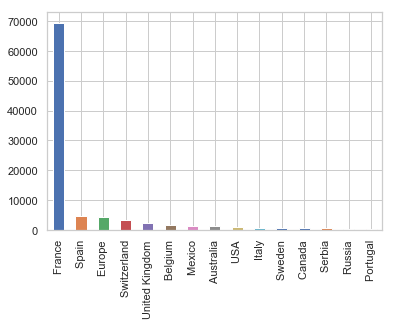

In [565]:
count[0:15].plot.bar()

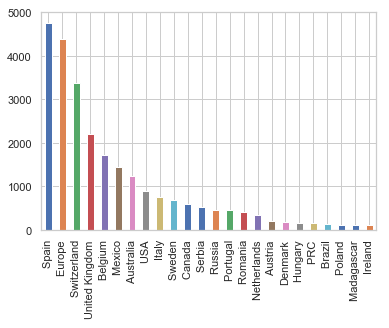

In [566]:
count[1:25].plot.bar()